In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd
import tensorflow as tf

# Random and os for reproducibility
import random
import os

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Processing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

from src.utils.time_series_procs import split_sequences

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def score_model(model, x, y, n_splits=10, n_repeats=10):
    scoring = "neg_root_mean_squared_error"
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)
    scores = cross_val_score(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

<IPython.core.display.Javascript object>

In [4]:
def plot_predictions(linreg_model, df, index, x, y):
    d = df["Data/Hora"].values
    test_series = pd.DataFrame({"ccs28": y}, index=pd.to_datetime(d))
    pred_series = linreg_model.predict(scaler.transform(x))
    pred_series = pd.DataFrame({"ccs28-pred": pred_series}, index=pd.to_datetime(d))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color="r")  # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(
        ["train and test series", "end of train series", "predicted"], loc="upper left"
    )
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
    plt.show()

<IPython.core.display.Javascript object>

In [5]:
def plot_scores_box_plot(scores, repeats, n_splits):
    plt.figure(figsize=(15, 8))
    plt.boxplot(
        scores.reshape((repeats, n_splits)),
        labels=[str(r) for r in range(1, repeats + 1)],
        showmeans=True,
    )
    plt.ylabel("RMSE", labelpad=20, fontsize=15)
    plt.xlabel("Repeats", labelpad=20, fontsize=15)
    plt.show()

<IPython.core.display.Javascript object>

In [6]:
class StandardScaler3DShape:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_transform(self, X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

    def fit(self, X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self

    def transform(self, X, y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

<IPython.core.display.Javascript object>

In [7]:
def repeated_blocking_time_series(
    Estimator, Transform, x, y, train_period, test_period, repeats=10, params=None
):
    results = []
    max_samples = x.shape[0]

    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples // (train_period + test_period)):
            scaler = Transform()
            model = Estimator() if params is None else Estimator(**params)
            x_train = x[i : i + train_period]
            y_train = y[i : i + train_period]
            x_test = x[i + train_period : i + train_period + test_period]
            y_test = y[i + train_period : i + train_period + test_period]
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            model.fit(x_train, y_train)

            y_train_pred = model.predict(x_train)
            y_test_pred = model.predict(x_test)
            scores.append(
                score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
            )
            i += train_period + test_period

        scores_final = {key: [] for key, _ in scores[0].items()}
        for scores_dict in scores:
            for key, value in scores_dict.items():
                scores_final[key] += [value]
        results.append(scores_final)
    return results

<IPython.core.display.Javascript object>

In [8]:
def print_scores(scores, METRICS, METRICS_DICT):
    for phase in ["train", "test"]:
        print("******")
        print(f"[{phase.upper()}]")
        print("******")
        for metric in METRICS:
            name = METRICS_DICT[metric]
            print(
                f"{name}: %.3f (%.3f)"
                % (
                    np.abs(np.mean(scores[f"{phase}_" + metric])),
                    np.std(scores[f"{phase}_" + metric]),
                )
            )
        print("\n======================\n")

<IPython.core.display.Javascript object>

In [9]:
def score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred):
    TRAIN_RMSE = mean_squared_error(y_true=y_train, y_pred=y_train_pred, squared=False)
    TRAIN_MAE = mean_absolute_error(y_true=y_train, y_pred=y_train_pred)
    TRAIN_MAPE = mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_pred)
    TRAIN_R2 = r2_score(y_true=y_train, y_pred=y_train_pred)

    TEST_RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    TEST_MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    TEST_MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    TEST_R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "train_neg_root_mean_squared_error": TRAIN_RMSE,
        "train_neg_mean_absolute_error": TRAIN_MAE,
        "train_neg_mean_absolute_percentage_error": TRAIN_MAPE,
        "train_r2": TRAIN_R2,
        "test_neg_root_mean_squared_error": TEST_RMSE,
        "test_neg_mean_absolute_error": TEST_MAE,
        "test_neg_mean_absolute_percentage_error": TEST_MAPE,
        "test_r2": TEST_R2,
    }
    return scores

<IPython.core.display.Javascript object>

In [10]:
def get_model(shape, include_top=True):
    timesteps, number_of_features = shape
    inputs = tf.keras.Input(shape=(timesteps, number_of_features))
    x = tf.keras.layers.Conv1D(128, 24, activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(64, 12, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(32, 6, activation="relu", padding="same")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    if include_top == True:
        x = tf.keras.layers.Flatten(name="flatten")(x)
        x = tf.keras.layers.Dense(128, activation="relu", name="fc1")(x)
        x = tf.keras.layers.Dense(64, activation="relu", name="fc2")(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
    else:
        model = tf.keras.Model(inputs, x)
    return model

<IPython.core.display.Javascript object>

# Settings for Reproducibility

In [11]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

<IPython.core.display.Javascript object>

In [12]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

# Baseline Model

# 1. Linear Regression

# Intercement

In [13]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

In [14]:
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28").values
x = df_no_cs.drop(["Data"], axis=1)

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [15]:
repeats = 10
n_splits = 10
set_seeds()
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 3.769 (0.037)
MAE: 2.892 (0.021)
MAPE: 0.063 (0.001)
R2: 0.706 (0.006)


******
[TEST]
******
RMSE: 3.803 (0.326)
MAE: 2.904 (0.087)
MAPE: 0.063 (0.002)
R2: 0.697 (0.055)




<IPython.core.display.Javascript object>

# partner_iii

In [16]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [17]:
y = df_partner_iii.pop("28d compressive strength (MPa)").values
x = df_partner_iii.values

<IPython.core.display.Javascript object>

In [18]:
repeats = 10
n_splits = 10
set_seeds()
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 5.137 (0.055)
MAE: 3.990 (0.047)
MAPE: 0.079 (0.001)
R2: 0.463 (0.014)


******
[TEST]
******
RMSE: 5.165 (0.490)
MAE: 4.030 (0.426)
MAPE: 0.080 (0.009)
R2: 0.417 (0.145)




<IPython.core.display.Javascript object>

# partner_ii

In [19]:
df = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()

y = df_no_cs.pop("strength_28d").values
x = df_no_cs.drop(["sample_date"], axis=1)

<IPython.core.display.Javascript object>

In [20]:
repeats = 10
n_splits = 10
set_seeds()
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 2.195 (0.021)
MAE: 1.749 (0.016)
MAPE: 0.041 (0.000)
R2: 0.614 (0.007)


******
[TEST]
******
RMSE: 2.263 (0.207)
MAE: 1.787 (0.137)
MAPE: 0.042 (0.003)
R2: 0.580 (0.080)




<IPython.core.display.Javascript object>

# Transfer Learning - Conv1D


## Pre Trainning

In [21]:
batch_size = 32
epochs = 200
verbose = 0
timesteps = 5

<IPython.core.display.Javascript object>

# Intercement

In [22]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [23]:
set_seeds()
model = get_model(shape=(timesteps, x.shape[-1]))
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

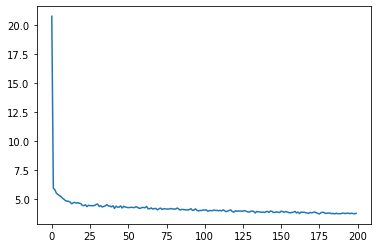

<IPython.core.display.Javascript object>

In [24]:
plt.plot(history.history["RMSE"])

In [25]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.456 (0.000)
MAE: 1.866 (0.000)
MAPE: 0.042 (0.000)
R2: 0.855 (0.000)


******
[TEST]
******
RMSE: 4.469 (0.000)
MAE: 3.688 (0.000)
MAPE: 0.070 (0.000)
R2: 0.410 (0.000)




<IPython.core.display.Javascript object>

In [26]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [27]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [28]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [29]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [30]:
sc = StandardScaler3DShape()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

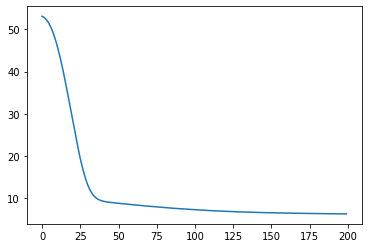

<IPython.core.display.Javascript object>

In [31]:
plt.plot(history.history["RMSE"])

In [32]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 6.342 (0.000)
MAE: 4.828 (0.000)
MAPE: 0.100 (0.000)
R2: 0.248 (0.000)


******
[TEST]
******
RMSE: 3.916 (0.000)
MAE: 2.912 (0.000)
MAPE: 0.057 (0.000)
R2: 0.050 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [33]:
batch_size = 32
epochs = 100
verbose = 0
timesteps = 5

<IPython.core.display.Javascript object>

In [34]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [35]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i.drop(["Date"], axis=1)
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [36]:
set_seeds()
model = get_model(shape=(timesteps, x.shape[-1]))
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

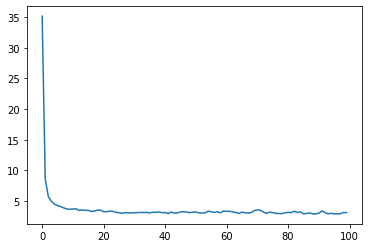

<IPython.core.display.Javascript object>

In [37]:
plt.plot(history.history["RMSE"])

In [38]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.349 (0.000)
MAE: 0.936 (0.000)
MAPE: 0.022 (0.000)
R2: 0.929 (0.000)


******
[TEST]
******
RMSE: 2.614 (0.000)
MAE: 1.691 (0.000)
MAPE: 0.038 (0.000)
R2: 0.721 (0.000)




<IPython.core.display.Javascript object>

In [39]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [40]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [41]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

<IPython.core.display.Javascript object>

In [42]:
set_seeds()

model_2 = get_model(include_top=True, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [43]:
sc = StandardScaler3DShape()
history = model.fit(
    sc.fit_transform(x[:-48]), y[:-48], batch_size=batch_size, epochs=epochs, verbose=0
)

<IPython.core.display.Javascript object>

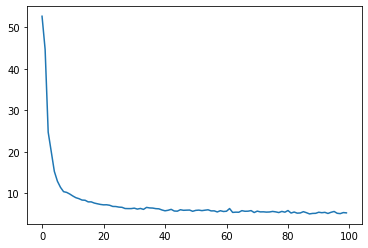

<IPython.core.display.Javascript object>

In [44]:
plt.plot(history.history["RMSE"])

In [45]:
y_train_pred = model.predict(sc.transform(x[:-48]))
y_train = y[:-48]
y_test_pred = model.predict(sc.transform(x[-48:]))
y_test = y[-48:]

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.120 (0.000)
MAE: 3.225 (0.000)
MAPE: 0.064 (0.000)
R2: 0.682 (0.000)


******
[TEST]
******
RMSE: 4.734 (0.000)
MAE: 3.627 (0.000)
MAPE: 0.072 (0.000)
R2: 0.517 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [46]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [47]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [48]:
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

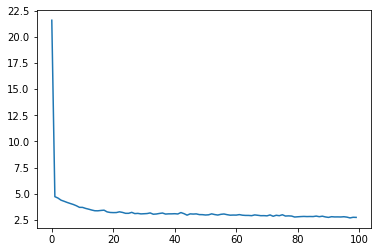

<IPython.core.display.Javascript object>

In [49]:
plt.plot(history.history["RMSE"])

In [50]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.771 (0.000)
MAE: 2.066 (0.000)
MAPE: 0.047 (0.000)
R2: 0.815 (0.000)


******
[TEST]
******
RMSE: 4.558 (0.000)
MAE: 3.324 (0.000)
MAPE: 0.064 (0.000)
R2: 0.387 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_ii

In [51]:
batch_size = 32
epochs = 100
verbose = 0
timesteps = 5

<IPython.core.display.Javascript object>

In [52]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")

<IPython.core.display.Javascript object>

In [53]:
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.drop(["sample_date"], axis=1)


x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [54]:
set_seeds()
model = get_model(shape=(timesteps, x.shape[-1]))
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

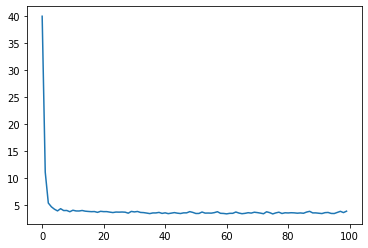

<IPython.core.display.Javascript object>

In [55]:
plt.plot(history.history["RMSE"])

In [56]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.353 (0.000)
MAE: 1.866 (0.000)
MAPE: 0.042 (0.000)
R2: 0.476 (0.000)


******
[TEST]
******
RMSE: 3.274 (0.000)
MAE: 2.507 (0.000)
MAPE: 0.064 (0.000)
R2: 0.378 (0.000)




<IPython.core.display.Javascript object>

In [57]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [58]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [59]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [60]:
set_seeds()

model_2 = get_model(include_top=True, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [61]:
sc = StandardScaler3DShape()
history = model.fit(
    sc.fit_transform(x_train), y_train, batch_size=batch_size, epochs=epochs, verbose=0
)

<IPython.core.display.Javascript object>

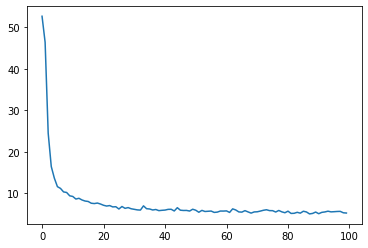

<IPython.core.display.Javascript object>

In [62]:
plt.plot(history.history["RMSE"])

In [63]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.013 (0.000)
MAE: 3.183 (0.000)
MAPE: 0.063 (0.000)
R2: 0.705 (0.000)


******
[TEST]
******
RMSE: 5.461 (0.000)
MAE: 4.059 (0.000)
MAPE: 0.081 (0.000)
R2: 0.010 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [64]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [65]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [66]:
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

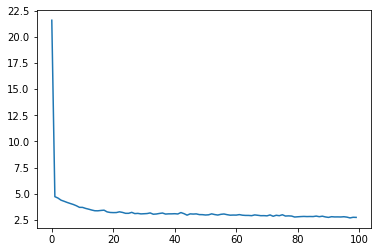

<IPython.core.display.Javascript object>

In [67]:
plt.plot(history.history["RMSE"])

In [68]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.771 (0.000)
MAE: 2.066 (0.000)
MAPE: 0.047 (0.000)
R2: 0.815 (0.000)


******
[TEST]
******
RMSE: 4.558 (0.000)
MAE: 3.324 (0.000)
MAPE: 0.064 (0.000)
R2: 0.387 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i + partner_ii

In [69]:
batch_size = 32
epochs = 200
verbose = 0
timesteps = 7

<IPython.core.display.Javascript object>

In [70]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y_1 = df_no_cs.pop("strength_28d")
x_1 = df_no_cs.drop(["sample_date"], axis=1)

df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y_2 = df_partner_i.pop("28 day Compressive strength")
x_2 = df_partner_i.drop(["Date"], axis=1)

x_2.columns = x_2.columns.str.lower()
x_2 = x_2.drop(set(x_2.columns) - set(x_1.columns), axis=1)
x_1 = x_1[x_2.columns]

y_1.name = "cs28"
y_2.name = "cs28"

x = pd.concat([x_1, x_2], axis=0).reset_index(drop=True)
y = pd.concat([y_1, y_2], axis=0).reset_index(drop=True)

x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=True
)

<IPython.core.display.Javascript object>

In [71]:
set_seeds()

model = get_model(shape=(timesteps, x.shape[-1]))
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

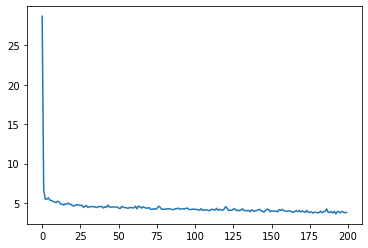

<IPython.core.display.Javascript object>

In [72]:
plt.plot(history.history["RMSE"])

In [73]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.992 (0.000)
MAE: 2.393 (0.000)
MAPE: 0.054 (0.000)
R2: 0.543 (0.000)


******
[TEST]
******
RMSE: 3.567 (0.000)
MAE: 2.740 (0.000)
MAPE: 0.063 (0.000)
R2: 0.338 (0.000)




<IPython.core.display.Javascript object>

In [74]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [75]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [76]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [77]:
set_seeds()

model_2 = get_model(include_top=True, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [78]:
sc = StandardScaler3DShape()
history = model.fit(
    sc.fit_transform(x_train), y_train, batch_size=batch_size, epochs=epochs, verbose=0
)

<IPython.core.display.Javascript object>

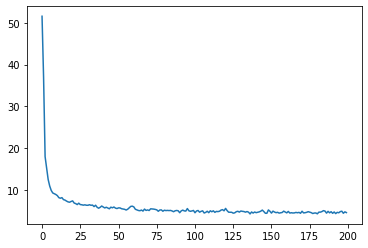

<IPython.core.display.Javascript object>

In [79]:
plt.plot(history.history["RMSE"])

In [80]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.532 (0.000)
MAE: 2.719 (0.000)
MAPE: 0.053 (0.000)
R2: 0.768 (0.000)


******
[TEST]
******
RMSE: 6.068 (0.000)
MAE: 4.957 (0.000)
MAPE: 0.097 (0.000)
R2: 1.520 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [81]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [82]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [83]:
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

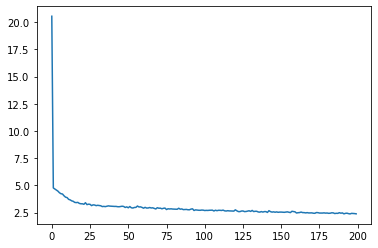

<IPython.core.display.Javascript object>

In [84]:
plt.plot(history.history["RMSE"])

In [85]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.279 (0.000)
MAE: 1.721 (0.000)
MAPE: 0.038 (0.000)
R2: 0.875 (0.000)


******
[TEST]
******
RMSE: 4.156 (0.000)
MAE: 3.230 (0.000)
MAPE: 0.061 (0.000)
R2: 0.490 (0.000)




<IPython.core.display.Javascript object>

In [86]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [87]:
set_seeds()
model = get_model(include_top=True, shape=(timesteps, x.shape[-1]))

<IPython.core.display.Javascript object>

In [88]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [89]:
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

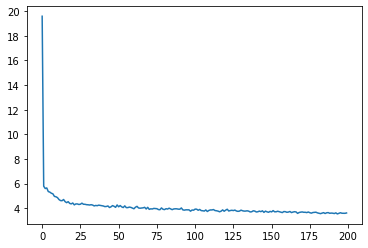

<IPython.core.display.Javascript object>

In [90]:
plt.plot(history.history["RMSE"])

In [91]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.452 (0.000)
MAE: 1.862 (0.000)
MAPE: 0.042 (0.000)
R2: 0.855 (0.000)


******
[TEST]
******
RMSE: 3.718 (0.000)
MAE: 2.859 (0.000)
MAPE: 0.055 (0.000)
R2: 0.592 (0.000)




<IPython.core.display.Javascript object>

# Experiments with Same Variables

# Baseline Model

# 1. Linear Regression

In [92]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

# Intercement

In [93]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

<IPython.core.display.Javascript object>

In [94]:
repeats = 10
n_splits = 10
set_seeds()
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 4.995 (0.050)
MAE: 3.799 (0.025)
MAPE: 0.082 (0.001)
R2: 0.483 (0.010)


******
[TEST]
******
RMSE: 5.028 (0.438)
MAE: 3.811 (0.113)
MAPE: 0.082 (0.002)
R2: 0.471 (0.096)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [95]:
batch_size = 32
epochs = 200
verbose = 0
timesteps = 30

<IPython.core.display.Javascript object>

In [96]:
df_intercement = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [97]:
to_drop = set(df_partner_i.columns.str.lower()) - set(
    df_intercement.columns.str.lower()
)
df_partner_i.columns = df_partner_i.columns.str.lower()
df_partner_i.drop(to_drop, axis=1)

,mgo,al2o3,sio2,so3,k2o,fe2o3
0,3.67285,4.27263,18.556379,4.43558,1.21612,2.79746
1,2.53917,4.30627,18.414921,2.54332,1.22146,3.03862
2,2.57985,4.15108,18.481070,2.98196,1.12279,3.07343
3,3.71899,4.25718,18.616140,4.42556,1.19938,2.76630
4,2.56056,4.18035,17.636169,4.07796,1.20883,3.03309
...,...,...,...,...,...,...
1229,2.69335,4.35530,18.473740,4.19836,1.21207,3.02851
1230,2.25720,4.08649,17.420740,3.76640,1.17111,2.93249
1231,2.69857,4.42368,18.693199,3.06924,1.21522,3.02881
1232,2.58789,4.16096,17.674860,4.07574,1.19196,3.04040


<IPython.core.display.Javascript object>

In [98]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [99]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [100]:
x_train.shape

(964, 30, 6)

<IPython.core.display.Javascript object>

In [101]:
set_seeds()
model = get_model(shape=(timesteps, x_train.shape[-1]))
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

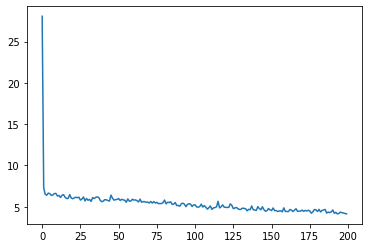

<IPython.core.display.Javascript object>

In [102]:
plt.plot(history.history["RMSE"])

In [103]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.963 (0.000)
MAE: 2.278 (0.000)
MAPE: 0.055 (0.000)
R2: 0.659 (0.000)


******
[TEST]
******
RMSE: 3.691 (0.000)
MAE: 2.792 (0.000)
MAPE: 0.066 (0.000)
R2: 0.439 (0.000)




<IPython.core.display.Javascript object>

In [104]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [105]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [106]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [107]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [108]:
sc = StandardScaler3DShape()
history = model.fit(
    sc.fit_transform(x_train), y_train, batch_size=batch_size, epochs=epochs, verbose=0
)

<IPython.core.display.Javascript object>

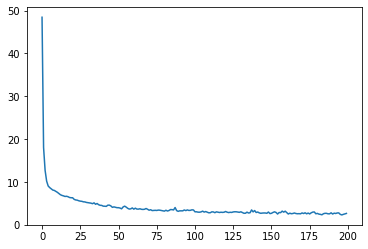

<IPython.core.display.Javascript object>

In [109]:
plt.plot(history.history["RMSE"])

In [110]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.557 (0.000)
MAE: 1.573 (0.000)
MAPE: 0.031 (0.000)
R2: 0.876 (0.000)


******
[TEST]
******
RMSE: 5.605 (0.000)
MAE: 4.625 (0.000)
MAPE: 0.090 (0.000)
R2: 1.137 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [111]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [112]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(128, activation="relu")(class1)
class1 = tf.keras.layers.Dense(64, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [113]:
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

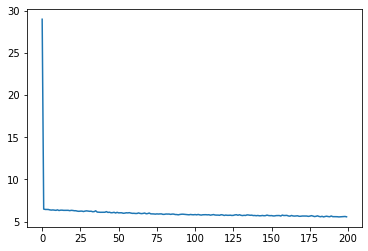

<IPython.core.display.Javascript object>

In [114]:
plt.plot(history.history["RMSE"])

In [115]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 5.459 (0.000)
MAE: 4.611 (0.000)
MAPE: 0.104 (0.000)
R2: 0.285 (0.000)


******
[TEST]
******
RMSE: 7.367 (0.000)
MAE: 6.072 (0.000)
MAPE: 0.111 (0.000)
R2: 0.596 (0.000)




<IPython.core.display.Javascript object>

In [116]:
df_no_cs.shape

(5561, 10)

<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i + partner_ii

In [117]:
batch_size = 32
epochs = 200
verbose = 0
timesteps = 30

<IPython.core.display.Javascript object>

In [118]:
df_intercement = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [119]:
to_drop = set(df_partner_i.columns.str.lower()) - set(
    df_intercement.columns.str.lower()
)
df_partner_i.columns = df_partner_i.columns.str.lower()
df_partner_i.drop(to_drop, axis=1)

,mgo,al2o3,sio2,so3,k2o,fe2o3
0,3.67285,4.27263,18.556379,4.43558,1.21612,2.79746
1,2.53917,4.30627,18.414921,2.54332,1.22146,3.03862
2,2.57985,4.15108,18.481070,2.98196,1.12279,3.07343
3,3.71899,4.25718,18.616140,4.42556,1.19938,2.76630
4,2.56056,4.18035,17.636169,4.07796,1.20883,3.03309
...,...,...,...,...,...,...
1229,2.69335,4.35530,18.473740,4.19836,1.21207,3.02851
1230,2.25720,4.08649,17.420740,3.76640,1.17111,2.93249
1231,2.69857,4.42368,18.693199,3.06924,1.21522,3.02881
1232,2.58789,4.16096,17.674860,4.07574,1.19196,3.04040


<IPython.core.display.Javascript object>

In [120]:
to_drop = set(df_partner_ii.columns.str.lower()) - set(
    df_intercement.columns.str.lower()
)
df_partner_ii.columns = df_partner_ii.columns.str.lower()
df_partner_ii.drop(to_drop, axis=1)

,sio2,al2o3,fe2o3,mgo,so3,k2o
0,19.42,4.86,3.22,3.74,3.08,0.68
1,19.63,4.90,3.30,3.50,2.89,0.65
2,19.30,4.80,3.23,3.60,3.20,0.67
3,19.28,4.81,3.29,3.48,2.85,0.66
4,19.29,4.85,3.33,3.47,2.87,0.69
...,...,...,...,...,...,...
1052,19.52,4.39,3.25,2.26,3.39,0.61
1053,18.11,4.19,3.03,2.26,3.13,0.59
1054,18.10,4.21,3.03,2.26,3.08,0.59
1055,18.02,4.15,2.99,2.33,3.12,0.60


<IPython.core.display.Javascript object>

In [121]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [122]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y_1 = df_no_cs.pop("strength_28d")
x_1 = df_no_cs.rename({"sample_date": "date"}, axis=1)

df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y_2 = df_partner_i.pop("28 day Compressive strength")
x_2 = df_partner_i

x_2.columns = x_2.columns.str.lower()
x_2 = x_2.drop(set(x_2.columns) - set(x_1.columns), axis=1)
x_1 = x_1[x_2.columns]


y_1.name = "cs28"
y_2.name = "cs28"

x = pd.concat([x_1, x_2], axis=0).reset_index(drop=True)
y = pd.concat([y_1, y_2], axis=0).reset_index(drop=True)

x = pd.concat([x, y], axis=1)
x["date"] = x["date"].apply(lambda x: x[:10])
x["date"] = pd.to_datetime(x["date"])
x = x.sort_values(by="date").reset_index(drop=True)
y = x.pop("cs28")
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [123]:
set_seeds()

model = get_model(shape=(timesteps, x_train.shape[-1]))
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

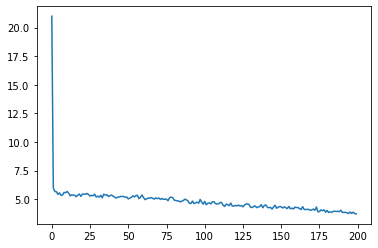

<IPython.core.display.Javascript object>

In [124]:
plt.plot(history.history["RMSE"])

In [125]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.565 (0.000)
MAE: 1.968 (0.000)
MAPE: 0.046 (0.000)
R2: 0.641 (0.000)


******
[TEST]
******
RMSE: 4.131 (0.000)
MAE: 3.233 (0.000)
MAPE: 0.080 (0.000)
R2: 0.259 (0.000)




<IPython.core.display.Javascript object>

In [126]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [127]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [128]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [129]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [130]:
sc = StandardScaler3DShape()
history = model.fit(
    sc.fit_transform(x_train), y_train, batch_size=batch_size, epochs=epochs, verbose=0
)

<IPython.core.display.Javascript object>

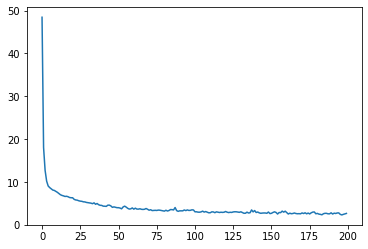

<IPython.core.display.Javascript object>

In [131]:
plt.plot(history.history["RMSE"])

In [132]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.557 (0.000)
MAE: 1.573 (0.000)
MAPE: 0.031 (0.000)
R2: 0.876 (0.000)


******
[TEST]
******
RMSE: 5.605 (0.000)
MAE: 4.625 (0.000)
MAPE: 0.090 (0.000)
R2: 1.137 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [133]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [134]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(128, activation="relu")(class1)
class1 = tf.keras.layers.Dense(64, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [135]:
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

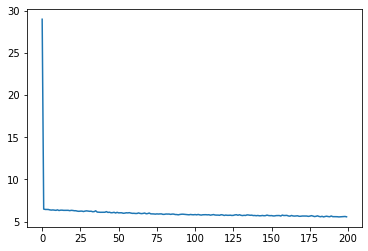

<IPython.core.display.Javascript object>

In [136]:
plt.plot(history.history["RMSE"])

In [137]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 5.459 (0.000)
MAE: 4.611 (0.000)
MAPE: 0.104 (0.000)
R2: 0.285 (0.000)


******
[TEST]
******
RMSE: 7.367 (0.000)
MAE: 6.072 (0.000)
MAPE: 0.111 (0.000)
R2: 0.596 (0.000)




<IPython.core.display.Javascript object>

In [138]:
df_no_cs.shape

(5561, 10)

<IPython.core.display.Javascript object>

# Baseline Model

# Linear Regression

In [139]:
COMMON_FEATURES = [
    "cao",
    "sio2",
    "al2o3",
    "fe2o3",
    "aluminate",
    "na2o",
    "mgo",
    "so3",
    "ferrite",
    "k2o",
]

<IPython.core.display.Javascript object>

# partner_ii

In [140]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.rename({"sample_date": "date"}, axis=1)

x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

<IPython.core.display.Javascript object>

In [141]:
repeats = 10
n_splits = 10
set_seeds()
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 2.708 (0.023)
MAE: 2.159 (0.018)
MAPE: 0.050 (0.000)
R2: 0.413 (0.009)


******
[TEST]
******
RMSE: 2.764 (0.231)
MAE: 2.190 (0.156)
MAPE: 0.051 (0.004)
R2: 0.375 (0.104)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [142]:
batch_size = 32
epochs = 200
verbose = 0
timesteps = 5

<IPython.core.display.Javascript object>

In [143]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [144]:
COMMON_FEATURES = [
    "cao",
    "sio2",
    "al2o3",
    "fe2o3",
    "aluminate",
    "na2o",
    "mgo",
    "so3",
    "ferrite",
    "k2o",
]

<IPython.core.display.Javascript object>

In [145]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [146]:
set_seeds()
model = get_model(shape=(timesteps, x_train.shape[-1]))
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

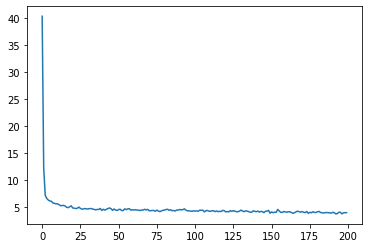

<IPython.core.display.Javascript object>

In [147]:
plt.plot(history.history["RMSE"])

In [148]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.391 (0.000)
MAE: 2.727 (0.000)
MAPE: 0.062 (0.000)
R2: 0.550 (0.000)


******
[TEST]
******
RMSE: 4.110 (0.000)
MAE: 3.328 (0.000)
MAPE: 0.075 (0.000)
R2: 0.311 (0.000)




<IPython.core.display.Javascript object>

In [149]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_ii

In [150]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.rename({"sample_date": "date"}, axis=1)

x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [151]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(128, activation="relu")(class1)
class1 = tf.keras.layers.Dense(64, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [152]:
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

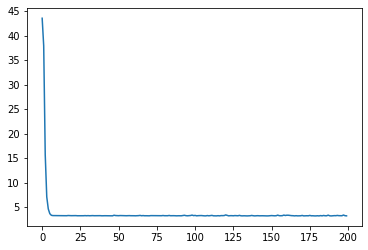

<IPython.core.display.Javascript object>

In [153]:
plt.plot(history.history["RMSE"])

In [154]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)


******
[TRAIN]
******
RMSE: 3.513 (0.000)
MAE: 2.994 (0.000)
MAPE: 0.070 (0.000)
R2: 0.168 (0.000)


******
[TEST]
******
RMSE: 6.033 (0.000)
MAE: 5.456 (0.000)
MAPE: 0.142 (0.000)
R2: 3.680 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [155]:
batch_size = 32
epochs = 200
verbose = 0
timesteps = 5

<IPython.core.display.Javascript object>

In [156]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [157]:
COMMON_FEATURES = ["%limestone", "%gypsum", "%clinker"]

<IPython.core.display.Javascript object>

In [158]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [159]:
set_seeds()
model = get_model(shape=(timesteps, x_train.shape[-1]))
sc = StandardScaler3DShape()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

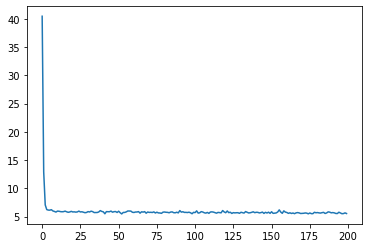

<IPython.core.display.Javascript object>

In [160]:
plt.plot(history.history["RMSE"])

In [161]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.818 (0.000)
MAE: 4.440 (0.000)
MAPE: 0.105 (0.000)
R2: 0.091 (0.000)


******
[TEST]
******
RMSE: 5.292 (0.000)
MAE: 5.060 (0.000)
MAPE: 0.117 (0.000)
R2: 0.142 (0.000)




<IPython.core.display.Javascript object>

In [162]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [163]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [164]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii
x, y = split_sequences(pd.concat([x, y], axis=1).values, timesteps)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [165]:
set_seeds()

model_2 = get_model(include_top=False, shape=(timesteps, x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [166]:
sc = StandardScaler3DShape()
history = model.fit(
    sc.fit_transform(x_train), y_train, batch_size=batch_size, epochs=epochs, verbose=0
)

<IPython.core.display.Javascript object>

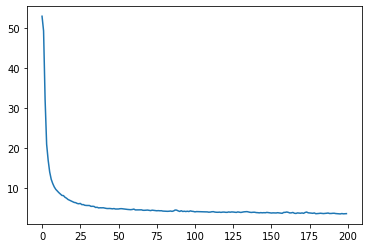

<IPython.core.display.Javascript object>

In [167]:
plt.plot(history.history["RMSE"])

In [168]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.537 (0.000)
MAE: 2.596 (0.000)
MAPE: 0.050 (0.000)
R2: 0.766 (0.000)


******
[TEST]
******
RMSE: 4.361 (0.000)
MAE: 3.300 (0.000)
MAPE: 0.065 (0.000)
R2: 0.301 (0.000)




<IPython.core.display.Javascript object>